# Test MH harmonic

In [1]:
import os, sys, time
import argparse
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
import scipy
import healpy as hp
import astropy.io.fits as fits
import camb
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax_healpy as jhp
import jax.random as random
import toml
import numpyro
from functools import partial
import micmac
from micmac import *
from fgbuster.observation_helpers import *

In [2]:
from jax import config
current_path = os.path.abspath('')
sys.path.append(current_path)

config.update("jax_enable_x64", True)

In [3]:
path_toml_file = current_path+'/Harm_fullsky_v1a.toml'
path_home_test_playground = os.path.dirname(current_path) + '/'

In [4]:
MICMAC_obj = create_Harmonic_MICMAC_sampler_from_toml_file(path_toml_file)


In [5]:
seed_realization_input = MICMAC_obj.seed

In [6]:
fgs_model_ = 'd0s0'
instr_name = MICMAC_obj.instrument_name #'SO_SAT'

path_Fisher = path_home_test_playground + f'Fisher_matrix_{MICMAC_obj.instrument_name}_EB_model_{fgs_model_}_noise_True_seed_42_lmin2_lmax128.txt'
try :
    Fisher_matrix = np.loadtxt(path_Fisher)
except:
    print("Fisher matrix not found !", flush=True)
    Fisher_matrix = np.loadtxt(path_home_test_playground + f'Fisher_matrix_{MICMAC_obj.instrument_name}_EB_model_d0s0_noise_True_seed_42_lmin2_lmax128.txt')


In [7]:
instrument = get_instrument(instr_name)


In [8]:
np.random.seed(seed_realization_input)
freq_maps_fgs_noised = get_observation(instrument, fgs_model_, nside=MICMAC_obj.nside, noise=True)[:, 1:, :]   # keep only Q and U
np.random.seed(seed_realization_input)
freq_maps_fgs_denoised = get_observation(instrument, fgs_model_, nside=MICMAC_obj.nside, noise=False)[:, 1:, :]   # keep only Q and U

noise_map = freq_maps_fgs_noised - freq_maps_fgs_denoised
 

freq_maps_fgs = freq_maps_fgs_denoised + noise_map


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [9]:
# Mixing matrix initialization
init_mixing_matrix_obj = micmac.InitMixingMatrix(np.array(instrument['frequency']), MICMAC_obj.n_components, pos_special_freqs=[0,-1])

init_params = init_mixing_matrix_obj.init_params()

mixing_matrix_obj = micmac.MixingMatrix(instrument['frequency'], MICMAC_obj.n_components, init_params, pos_special_freqs=[0,-1])
mixing_matrix_sampled = mixing_matrix_obj.get_B()



In [10]:
# frequency_inv_noise_cell = get_true_Cl_noise(instrument['depth_p'], MICMAC_obj.lmax)

# MICMAC_obj.freq_noise_c_ell = frequency_inv_noise_cell

In [11]:
covariance_matrix = np.linalg.inv(Fisher_matrix)

MICMAC_obj.covariance_step_size_B_f = covariance_matrix[:-1, :-1]
MICMAC_obj.step_size_r = np.sqrt(covariance_matrix[-1, -1])

In [12]:
input_freq_maps, input_cmb_maps, theoretical_red_cov_r0_total, theoretical_red_cov_r1_tensor = MICMAC_obj.generate_input_freq_maps_from_fgs(freq_maps_fgs, return_only_freq_maps=False)


Calculating spectra from CAMB !
Calculating spectra from CAMB !


In [13]:
theoretical_r0_total = get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total)
theoretical_r1_tensor = get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r1_tensor)

c_ell_approx = np.zeros((3,MICMAC_obj.lmax+1))
c_ell_approx[0,MICMAC_obj.lmin:] = theoretical_r0_total[0,:]
c_ell_approx[1,MICMAC_obj.lmin:] = theoretical_r0_total[1,:]

red_cov_approx_matrix = get_reduced_matrix_from_c_ell_jax(c_ell_approx)[MICMAC_obj.lmin:]

In [14]:
len_pos_special_freqs = len(MICMAC_obj.pos_special_freqs)

## Starting MH

In [15]:
minimum_std_Fisher_diag = jnp.diag(scipy.linalg.sqrtm(jnp.linalg.inv(Fisher_matrix)))
sigma_gap = 20
sigma_gap = 2000

dimension_free_param_B_f = 2*(MICMAC_obj.n_frequencies-len_pos_special_freqs)

In [16]:
np.random.seed(MICMAC_obj.seed)
first_guess = jnp.zeros(dimension_free_param_B_f)
first_guess = first_guess.at[MICMAC_obj.indexes_free_Bf].set(
    init_params.ravel(order='F')[MICMAC_obj.indexes_free_Bf] + minimum_std_Fisher_diag[:-1]*np.random.uniform(low=-sigma_gap,high=sigma_gap, size=(dimension_free_param_B_f)))
# first_guess = first_guess.at[MICMAC_obj.indexes_free_Bf].set(
#     np.random.uniform(low=0,high=1, size=(dimension_free_param_B_f)))
init_params_mixing_matrix = first_guess.reshape((MICMAC_obj.n_frequencies-len_pos_special_freqs),2,order='F')

first_guess_r = 1e-5

In [17]:
init_params_mixing_matrix

Array([[ 0.27700278, -0.04914415],
       [ 0.11490296,  0.0291463 ],
       [ 0.05119212,  0.10211056],
       [ 0.02394819,  0.46750283]], dtype=float64)

In [18]:

# def perform_harmonic_MH(self, input_freq_maps, c_ell_approx, init_params_mixing_matrix, theoretical_r0_total, theoretical_r1_tensor,
#                         initial_guess_r=0, covariance_B_f_r=None):
#     """ Perform Metropolis Hastings to find the best r and B_f in harmonic domain, given the other parameters

#         Parameters
#         ----------
#         input_freq_maps : data of initial frequency maps, dimensions [frequencies, nstokes, n_pix]
        
#         tot_cov_first_guess : total covariance first guess, composed of all c_ell correlations in order (for polarization [EE, BB, EB])

#         depth_p: depth for the noise covariance calculation, in uK.arcmin

#         c_ell_approx : 

#         init_params_mixing_matrix : 
        
#         pos_special_freqs :

#         Returns
#         -------
#     """

#     # Disabling all chex checks to speed up the code
#     # chx acts like an assert, but is JAX compatible
#     if self.disable_chex:
#         print("Disabling chex !!!", flush=True)
#         chx.disable_asserts()

#     # Series of tests

#     ## Getting only the relevant spectra
#     if self.nstokes == 2:
#         indices_to_consider = np.array([1,2,4])
#         partial_indices_polar = indices_to_consider[:self.nstokes]
#     elif self.nstokes == 1:
#         indices_to_consider = np.array([0])
#     else:
#         indices_to_consider = np.arange(6) # All auto- and cross-correlations

#     ## Testing the initial spectra given in case the sampling is done with r
    
#     assert len(theoretical_r0_total.shape) == 2
#     assert (theoretical_r0_total.shape[1] == self.lmax + 1 - self.lmin) #or (theoretical_r0_total.shape[1] == self.lmax + 1)
#     assert len(theoretical_r1_tensor.shape) == 2
#     assert theoretical_r1_tensor.shape[1] == theoretical_r0_total.shape[1]

#     theoretical_red_cov_r0_total = get_reduced_matrix_from_c_ell(theoretical_r0_total)
#     theoretical_red_cov_r1_tensor  = get_reduced_matrix_from_c_ell(theoretical_r1_tensor)

#     ## Testing the initial CMB spectra given
#     # if self.nstokes == 2 and (CMB_c_ell.shape[0] != len(indices_to_consider)):    
#     #     CMB_c_ell = CMB_c_ell[indices_to_consider,:]
#     #     c_ell_approx = c_ell_approx[indices_to_consider,:]
#     if self.nstokes == 2 and (c_ell_approx.shape[0] != len(indices_to_consider)):
#         c_ell_approx = c_ell_approx[indices_to_consider,:]
    
#     ## Testing the initial mixing matrix
#     if len(init_params_mixing_matrix.shape) == 1:
#         assert len(init_params_mixing_matrix) == (self.n_frequencies-len(self.pos_special_freqs))*(self.n_correlations-1)
#     else:
#         # assert len(init_params_mixing_matrix.shape) == 2
#         assert init_params_mixing_matrix.shape[0] == (self.n_frequencies-len(self.pos_special_freqs))
#         assert init_params_mixing_matrix.shape[1] == (self.n_correlations-1)


#     ## Final set of tests
#     # assert len(CMB_c_ell.shape) == 2
#     # assert CMB_c_ell.shape[1] == self.lmax + 1
#     assert len(c_ell_approx.shape) == 2
#     assert c_ell_approx.shape[1] == self.lmax + 1

#     assert len(input_freq_maps.shape) == 3
#     assert input_freq_maps.shape[0] == self.n_frequencies
#     assert input_freq_maps.shape[1] == self.nstokes
#     assert input_freq_maps.shape[2] == self.n_pix

#     # Preparing for the full Gibbs sampling
#     len_pos_special_freqs = len(self.pos_special_freqs)

#     ## Initial guesses
#     initial_eta = jnp.zeros((self.nstokes,self.n_pix))
#     params_mixing_matrix_init_sample = jnp.copy(init_params_mixing_matrix).reshape(
#                                         ((self.n_frequencies-len_pos_special_freqs),self.n_correlations-1), order='F')

#     ## CMB covariance preparation in the format [lmax,nstokes,nstokes]
#     red_cov_approx_matrix = jnp.array(get_reduced_matrix_from_c_ell(c_ell_approx)[self.lmin:,...])
    
#     ## Preparation of the mixing matrix
#     self.mixing_matrix_obj = MixingMatrix(self.frequency_array, self.n_components, params_mixing_matrix_init_sample, pos_special_freqs=self.pos_special_freqs)

#     ## Preparing the scalar quantities
#     PRNGKey = random.PRNGKey(self.seed)

#     dimension_param_B_f = (self.n_frequencies-len_pos_special_freqs)*(self.n_correlations-1)
#     n_correlations = self.n_correlations

#     ## Preparing the step-size for Metropolis-within-Gibbs of B_f sampling
#     if covariance_B_f_r is None:
#         if self.covariance_B_f is None:
#             raise ValueError("Please provide a covariance_B_f")
#             assert (self.covariance_B_f).shape == ((self.n_frequencies-len(pos_special_freqs))*(self.n_correlations-1),(self.n_frequencies-len(pos_special_freqs))*(self.n_correlations-1))
    
#         covariance_B_f_r = jnp.zeros((dimension_param_B_f+1, dimension_param_B_f+1))
#         covariance_B_f_r = covariance_B_f_r.at[:dimension_param_B_f,:dimension_param_B_f].set(self.covariance_B_f)
#         covariance_B_f_r = covariance_B_f_r.at[dimension_param_B_f,dimension_param_B_f].set(self.step_size_r**2)
#     else:
#         assert covariance_B_f_r.shape == (dimension_param_B_f+1,dimension_param_B_f+1)

#     print('Covariance B_f, r', covariance_B_f_r, flush=True)

#     ## Preparing input alms data
#     def wrapper_map2alm(maps_, lmax=self.lmax, n_iter=self.n_iter, nside=self.nside):
#         alm_T, alm_E, alm_B = hp.map2alm(
#             maps_.reshape((3, 12 * nside**2)), lmax=lmax, iter=n_iter
#         )
#         return np.array([alm_T, alm_E, alm_B])

#     @partial(jax.jit, static_argnums=(1))
#     def pure_call_map2alm(maps_, lmax):
#         shape_output = (3, (lmax + 1) * (lmax // 2 + 1))
#         return jax.pure_callback(
#             wrapper_map2alm,
#             jax.ShapeDtypeStruct(shape_output, np.complex128),
#             maps_.ravel(),
#         )
    
#     JAX_input_freq_maps = jnp.array(input_freq_maps)
#     def get_freq_alm(num_frequency):
#         input_map_extended = jnp.vstack((JAX_input_freq_maps[num_frequency,0], JAX_input_freq_maps[num_frequency,...]))
#         all_alms = jnp.array(pure_call_map2alm(input_map_extended, lmax=self.lmax))
#         return all_alms[3-self.nstokes:,...]

    
#     input_freq_alms = jax.vmap(get_freq_alm)(jnp.arange(self.n_frequencies))
#     freq_red_inverse_noise = jnp.einsum('fgl,sk->fglsk', self.freq_noise_c_ell, jnp.eye(self.nstokes))
#     noise_weighted_alm_data = frequency_alms_x_obj_red_covariance_cell_JAX(input_freq_alms, freq_red_inverse_noise, lmin=self.lmin, n_iter=self.n_iter)

#     print(f"Starting {self.number_iterations_sampling} iterations for harmonic run", flush=True)

#     MHState = namedtuple("MHState", ["u", "rng_key"])

#     class MetropolisHastings(numpyro.infer.mcmc.MCMCKernel):
#         sample_field = "u"

#         def __init__(self, log_proba, covariance_matrix):
#             self.log_proba = log_proba
#             self.covariance_matrix = covariance_matrix

#         def init(self, rng_key, num_warmup, init_params, model_args, model_kwargs):
#             return MHState(init_params, rng_key)

#         def sample(self, state, model_args, model_kwargs):
            
#             new_sample, rng_key = multivariate_Metropolis_Hasting_step_numpyro(state, 
#                             covariance_matrix=self.covariance_matrix, 
#                             log_proba=self.log_proba, 
#                             **model_kwargs)
#             return MHState(new_sample, rng_key)

#     mcmc_obj = MCMC(MetropolisHastings(log_proba=self.harmonic_marginal_probability, covariance_matrix=covariance_B_f_r), 
#                     num_warmup=0, 
#                     num_samples=self.number_iterations_sampling, 
#                     thinning=self.thinning, 
#                     num_chains=self.n_chains_MH, 
#                     progress_bar=True)

#     # Initializing r and B_f samples
#     init_params_mixing_matrix_r = jnp.concatenate((params_mixing_matrix_init_sample.ravel(order='F'), 
#                                                     jnp.array(initial_guess_r).reshape(1)))

#     time_start_sampling = time.time()
#     mcmc_obj.run(PRNGKey, 
#                     init_params=init_params_mixing_matrix_r, 
#                     noise_weighted_alm_data=noise_weighted_alm_data, 
#                     theoretical_red_cov_r1_tensor=theoretical_red_cov_r1_tensor, 
#                     theoretical_red_cov_r0_total=theoretical_red_cov_r0_total, 
#                     red_cov_approx_matrix=red_cov_approx_matrix)

#     time_full_chain = (time.time()-time_start_sampling)/60      
#     print(f"End of MH iterations for harmonic run in {time_full_chain} minutes, now saving results !", flush=True)
    
#     posterior_samples = mcmc_obj.get_samples()
#     print("Test", posterior_samples)
#     print("Test size", posterior_samples.shape, flush=True)
#     mcmc_obj.print_summary()

#     # Saving the samples as attributes of the Sampler object
#     self.update_samples_MH(posterior_samples)
#     self.number_iterations_done = self.number_iterations_sampling



In [19]:
MICMAC_obj.number_iterations_sampling = 20000

In [20]:
jnp.diag(sp.linalg.sqrtm(covariance_matrix))

Array([1.22719235e-04, 4.72984090e-05, 4.44084763e-05, 5.23546882e-05,
       4.28340683e-05, 1.62270766e-05, 1.52905384e-05, 1.82529746e-05,
       5.55036342e-04], dtype=float64)

In [21]:
# perform_harmonic_MH(MICMAC_obj, input_freq_maps, c_ell_approx, init_params_mixing_matrix, initial_guess_r=first_guess_r,
#                                     covariance_B_f_r=covariance_matrix, theoretical_r0_total=theoretical_r0_total, theoretical_r1_tensor=theoretical_r1_tensor)

MICMAC_obj.perform_harmonic_MH(input_freq_maps, c_ell_approx, init_params_mixing_matrix, initial_guess_r=first_guess_r,
                                    covariance_B_f_r=covariance_matrix, theoretical_r0_total=theoretical_r0_total, theoretical_r1_tensor=theoretical_r1_tensor)

Covariance B_f, r [[ 1.57489654e-08  2.71276909e-09  2.36835419e-09  1.51939102e-09
  -3.07091465e-09 -2.22079266e-10 -1.71572069e-10 -1.08678732e-10
   0.00000000e+00]
 [ 2.71276909e-09  3.60992230e-09  3.23728759e-09  2.20123320e-09
  -2.22092335e-10 -2.67787336e-10 -2.20384248e-10 -1.65635733e-10
  -0.00000000e+00]
 [ 2.36835419e-09  3.23728759e-09  3.35867742e-09  2.28038258e-09
  -1.71583988e-10 -2.20383790e-10 -2.75123127e-10 -2.01145001e-10
  -0.00000000e+00]
 [ 1.51939102e-09  2.20123320e-09  2.28038258e-09  3.39944797e-09
  -1.08682729e-10 -1.65630220e-10 -2.01140112e-10 -5.35936148e-10
   0.00000000e+00]
 [-3.07091465e-09 -2.22092335e-10 -1.71583988e-10 -1.08682729e-10
   2.22105731e-09  3.30205693e-10  2.84475588e-10  1.82264589e-10
  -0.00000000e+00]
 [-2.22079266e-10 -2.67787336e-10 -2.20383790e-10 -1.65630220e-10
   3.30205693e-10  4.34708081e-10  3.86465385e-10  2.65474299e-10
   0.00000000e+00]
 [-1.71572069e-10 -2.20384248e-10 -2.75123127e-10 -2.01140112e-10
   2.84475

sample: 100%|██████████| 20000/20000 [20:07<00:00, 16.56it/s]  

End of MH iterations for harmonic run in 20.137281250953674 minutes, now saving results !
Test [[2.77002783e-01 1.14902959e-01 5.11921171e-02 ... 1.02110555e-01
  4.67502829e-01 1.00000000e-05]
 [2.76972273e-01 1.14859819e-01 5.11056823e-02 ... 1.02140260e-01
  4.67514742e-01 1.16562979e-03]
 [2.76972273e-01 1.14859819e-01 5.11056823e-02 ... 1.02140260e-01
  4.67514742e-01 1.16562979e-03]
 ...
 [3.38694608e-01 2.97189103e-02 1.00401570e-02 ... 1.29149749e-01
  4.40794356e-01 8.04716722e-03]
 [3.38694608e-01 2.97189103e-02 1.00401570e-02 ... 1.29149749e-01
  4.40794356e-01 8.04716722e-03]
 [3.38498248e-01 2.97044804e-02 1.00562382e-02 ... 1.29145329e-01
  4.40793825e-01 9.20264688e-03]]
Test size (20000, 9)



                mean       std    median      5.0%     95.0%     n_eff     r_hat
Param:0[0]      0.34      0.02      0.34      0.30      0.36      3.64      1.36
Param:0[1]      0.07      0.03      0.07      0.03      0.10      2.47      2.70
Param:0[2]      0.03      0.02      0.05      0.01      0.05      2.83      1.99
Param:0[3]      0.02      0.01      0.02      0.00      0.02      3.17      1.69
Param:0[4]     -0.01      0.02     -0.02     -0.04      0.01      2.45      2.75
Param:0[5]      0.04      0.01      0.03      0.03      0.05      2.79      1.94
Param:0[6]      0.11      0.01      0.10      0.10      0.13      2.62      2.26
Param:0[7]      0.44      0.01      0.44      0.43      0.46      3.17      1.67
Param:0[8]      0.26      0.16      0.26      0.01      0.51      5.08      1.06



In [22]:
MICMAC_obj.all_samples_r.shape

(20000,)

In [23]:
MICMAC_obj.all_params_mixing_matrix_samples.shape

(20000, 4, 2)

In [24]:
list_correl = ['EE', 'BB', 'EB']

ell_arange = np.arange(red_cov_approx_matrix.shape[0]) + MICMAC_obj.lmin

frequency_Bf = np.array(instrument['frequency'][1:-1])

all_B_f_sample_synch = MICMAC_obj.all_params_mixing_matrix_samples[:,:,0]
all_B_f_sample_dust = MICMAC_obj.all_params_mixing_matrix_samples[:,:,1]

frequency_array = np.array(instrument['frequency'])


if MICMAC_obj.n_frequencies-len_pos_special_freqs < 10:
    plt.figure(figsize=(20,8))
    plt.suptitle('Mixing matrix parameters sampled vs iterations', fontsize=14)
    # plt.subplot(121)

    for i in range(MICMAC_obj.n_frequencies-len_pos_special_freqs):
        plt.subplot(201+len(frequency_Bf)*10+i)
        plt.title((f'Synch ${frequency_Bf[i]} GHz$'))
        plt.plot([0,MICMAC_obj.number_iterations_sampling], [init_params[i,0],init_params[i,0]], label='Exact value')
        plt.plot(np.arange(MICMAC_obj.number_iterations_sampling), all_B_f_sample_synch[:,i], '-.', label='Sample')
        
        n_sigma = 3
        transformed_samples = np.abs(all_B_f_sample_synch[:,i] - all_B_f_sample_synch[:,i].mean())/(all_B_f_sample_synch[:,i].std()) #< n_sigma
        cond = np.exp(transformed_samples**2/2)/(np.sqrt(2*np.pi)) < 0.9973
        mean_B_f = np.round(all_B_f_sample_synch[:,i][cond].mean(), decimals=5)
        std_B_f = np.round(all_B_f_sample_synch[:,i][cond].std(), decimals=5)

        mean_value = all_B_f_sample_synch[:,i].mean()
        plt.plot([0,MICMAC_obj.number_iterations_sampling], [mean_B_f,mean_B_f], ':', label='Samples mean 99.7%')

        # plt.yscale('log')
        # plt.xlabel('Iterations')
        if i == 0:
            plt.ylabel('Amplitude')
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
    # plt.loglog()

    # plt.figure(figsize=(20,8))
    # plt.subplot(122)
    for i in range(MICMAC_obj.n_frequencies-len_pos_special_freqs):
        plt.subplot(201+len(frequency_Bf)*10+i+len(frequency_Bf))
        # plt.subplot(201+len(frequency_Bf)*10+i)
        plt.title((f'Dust ${frequency_Bf[i]} GHz$'))
        plt.plot([0,MICMAC_obj.number_iterations_sampling], [init_params[i,1],init_params[i,1]], label='Exact value')
        plt.plot(np.arange(MICMAC_obj.number_iterations_sampling), all_B_f_sample_dust[:,i], '-.', label='Sample')

        n_sigma = 3
        transformed_samples = np.abs(all_B_f_sample_dust[:,i] - all_B_f_sample_dust[:,i].mean())/(all_B_f_sample_dust[:,i].std()) #< n_sigma
        cond = np.exp(transformed_samples**2/2)/(np.sqrt(2*np.pi)) < 0.9973
        mean_B_f = np.round(all_B_f_sample_dust[:,i][cond].mean(), decimals=5)
        std_B_f = np.round(all_B_f_sample_dust[:,i][cond].std(), decimals=5)

        mean_value = all_B_f_sample_dust[:,i].mean()
        plt.plot([0,MICMAC_obj.number_iterations_sampling], [mean_B_f,mean_B_f], ':', label='Samples mean 99.7%')
        # plt.yscale('log')
        plt.xlabel('Iterations')
        if i == 0:
            plt.ylabel('Amplitude')
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
    # plt.loglog()

    plt.show()

(20000,) 20000


/Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  fig.canvas.print_figure(bytes_io, **kw)


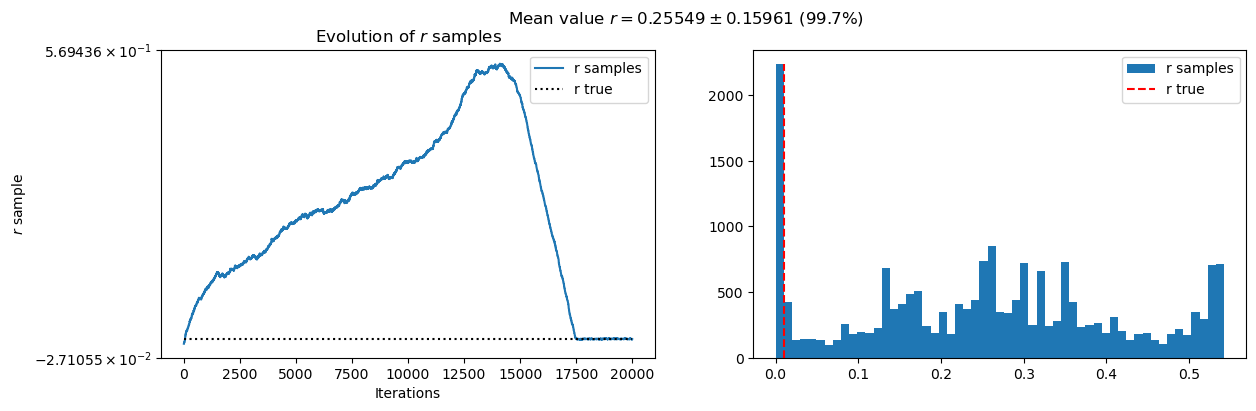

In [25]:
plt.figure(figsize=(14,4))

n_sigma = 3

all_r_samples = MICMAC_obj.all_samples_r

cond = np.abs((all_r_samples - all_r_samples.mean())/(all_r_samples.std())) < n_sigma
print(all_r_samples[cond].shape, MICMAC_obj.number_iterations_sampling)
mean_r = np.round(all_r_samples[cond].mean(), decimals=5)
std_r = np.round(all_r_samples[cond].std(), decimals=5)


plt.suptitle(f"Mean value $r = {mean_r} \pm {std_r}$ (99.7%)")

plt.subplot(121)
plt.plot(np.arange(MICMAC_obj.number_iterations_sampling), all_r_samples, label='r samples')
plt.plot([0, MICMAC_obj.number_iterations_sampling], [MICMAC_obj.r_true,MICMAC_obj.r_true], 'k:', label='r true')


plt.xlabel("Iterations")
plt.ylabel('$r$ sample')
plt.title(r'Evolution of $r$ samples')
plt.yscale('symlog')
plt.legend()
# plt.ylim(ymin=MICMAC_obj.r_true*.7, ymax=MICMAC_obj.r_true*1.3)

plt.subplot(122)
hist_values, bins_value, _ = plt.hist(all_r_samples, bins='rice', label='r samples')
plt.plot([MICMAC_obj.r_true,MICMAC_obj.r_true], [0,hist_values.max()], 'r--', label='r true')
plt.legend()
plt.show()

## Gelman-Rubin test

In [26]:
def get_Gelman_Rubin_statistics(all_chain_samples):
    """ Compute Gelman-Rubin statistics

        Parameters
        ----------
        :param all_chains_samples: all chains, with dimensions [n_chains, number_iterations, ...]
    """

    mean_chain = all_chain_samples.mean(axis=0)

    return 1/all_chain_samples.var(axis=1)*mean_chain.var(axis=0)